In [3]:
#Imports
import pandas as pd
import numpy as np

In [4]:
df_raw = pd.read_csv('fraud.csv')

In [5]:
df_raw.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [6]:
df_raw.dtypes

step             int64
customer        object
age             object
gender          object
zipcodeOri      object
merchant        object
zipMerchant     object
category        object
amount         float64
fraud            int64
dtype: object

In [ ]:
df_raw.info() # We have no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [ ]:
#Study cardinality of each column
columns = df_raw.columns.tolist()

for column in columns:
    print(f"{column}: {df_raw[column].nunique()} unique values") 

step: 180 unique values
customer: 4112 unique values
age: 8 unique values
gender: 4 unique values
zipcodeOri: 1 unique values
merchant: 50 unique values
zipMerchant: 1 unique values
category: 15 unique values
amount: 23767 unique values
fraud: 2 unique values


In [10]:
df_raw.drop(columns=['zipcodeOri', 'zipMerchant'], inplace=True) # Drop columns with only one unique value

In [17]:
#Convert step to hour_of_day
df_raw['hour_of_day'] = df_raw['step'] % 24

#Make feature to indicate if transaction was made at night
df_raw['is_night'] = (df_raw['hour_of_day'] >= 0) & (df_raw['hour_of_day'] <= 6)

In [21]:
df_raw['age'].value_counts()

age
'2'    187310
'3'    147131
'4'    109025
'5'     62642
'1'     58131
'6'     26774
'0'      2452
'U'      1178
Name: count, dtype: int64

In [40]:
#Since we only have 1178 unkown values for age, i will mark them in a separate flag
df_raw['age_unknown'] = (df_raw['age'] == 'U').astype(int)

#For known ages I will convert to numeric to preserve ordinality
valid_buckets = {"'" + str(i) + "'": i for i in range(7)}   # '0'->0, ... '6'->6
df_raw['age_ord'] = df_raw['age'].map(valid_buckets).astype('Float64').fillna(-1)


In [49]:
#Handle categorical variables

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

category_encoded = ohe.fit_transform(df_raw[['category']])
category_columns = ohe.get_feature_names_out(['category'])
category_df = pd.DataFrame(category_encoded.toarray(), 
                          columns=category_columns,
                          index=df_raw.index)

In [48]:
category_columns

array(["category_'es_barsandrestaurants'", "category_'es_contents'",
       "category_'es_fashion'", "category_'es_food'",
       "category_'es_health'", "category_'es_home'",
       "category_'es_hotelservices'", "category_'es_hyper'",
       "category_'es_leisure'", "category_'es_otherservices'",
       "category_'es_sportsandtoys'", "category_'es_tech'",
       "category_'es_transportation'", "category_'es_travel'",
       "category_'es_wellnessandbeauty'"], dtype=object)

In [19]:
cust_agg = df_raw.groupby('customer').agg(
    cust_tx_count=('step','count'),
    cust_mean_amount=('amount','mean'),
    cust_std_amount=('amount','std'),
    cust_fraud_rate=('fraud','mean')
).reset_index()

In [20]:
cust_agg

,customer,cust_tx_count,cust_mean_amount,cust_std_amount,cust_fraud_rate
0,'C1000148617',131,35.091908,36.863536,0.007634
1,'C100045114',109,90.336239,381.812802,0.045872
2,'C1000699316',94,38.154894,41.544414,0.000000
3,'C1001065306',30,204.754667,306.240251,0.366667
4,'C1002658784',131,34.253282,27.820062,0.000000
...,...,...,...,...,...
4107,'C99729647',175,32.555771,30.641718,0.000000
4108,'C998690782',171,61.211637,421.233339,0.011696
4109,'C998987490',177,32.273107,30.122381,0.000000
4110,'C999393223',142,36.018944,48.619220,0.014085


In [16]:
df_raw['age'].value_counts()

age
'2'    187310
'3'    147131
'4'    109025
'5'     62642
'1'     58131
'6'     26774
'0'      2452
'U'      1178
Name: count, dtype: int64

In [17]:
df_raw['zipMerchant'].value_counts()

zipMerchant
'28007'    594643
Name: count, dtype: int64

In [19]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [20]:
df_raw.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


In [21]:
df_raw.fraud.value_counts(normalize=True)

fraud
0    0.987892
1    0.012108
Name: proportion, dtype: float64

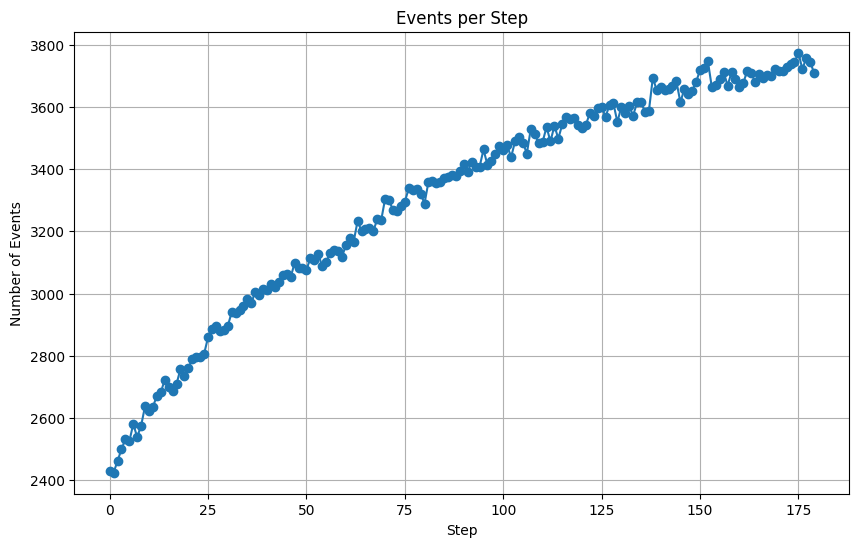

In [25]:
from matplotlib import pyplot as plt
events_per_step = df_raw.groupby('step').size()

plt.figure(figsize=(10, 6))
plt.plot(events_per_step.index, events_per_step.values, marker='o')
plt.title('Events per Step')
plt.xlabel('Step')
plt.ylabel('Number of Events')
plt.grid(True)
plt.show()


In [ ]:
fraud_rate_by_step = df_raw.groupby('step')['fraud'].mean()
print(fraud_rate_by_step)

step
0      0.016461
1      0.016502
2      0.016247
3      0.016006
4      0.015798
         ...   
175    0.010599
176    0.010750
177    0.010644
178    0.010687
179    0.010785
Name: fraud, Length: 180, dtype: float64


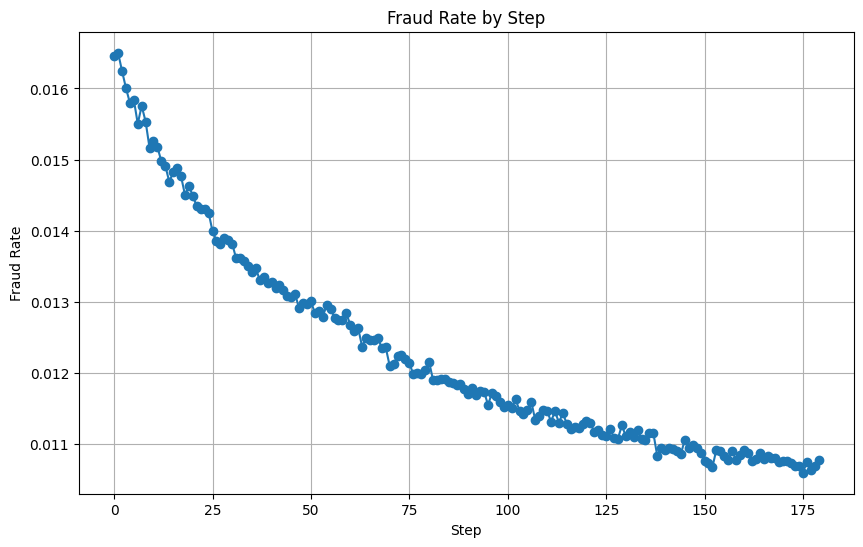

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(fraud_rate_by_step.index, fraud_rate_by_step.values, marker='o')
plt.title('Fraud Rate by Step')
plt.xlabel('Step')
plt.ylabel('Fraud Rate')
plt.grid(True)
plt.show()

In [26]:
# 1. Transactions per customer (count)
transactions_per_customer = df_raw.groupby('customer').size()
print("Transactions per customer:")
print(transactions_per_customer.describe())

Transactions per customer:
count    4112.000000
mean      144.611625
std        42.788212
min         5.000000
25%       130.000000
50%       165.000000
75%       173.000000
max       265.000000
dtype: float64


In [27]:
# 2. Fraud rate per customer
fraud_per_customer = df_raw.groupby('customer')['fraud'].mean()
print("\nFraud rate per customer:")
print(fraud_per_customer.describe())


Fraud rate per customer:
count    4112.000000
mean        0.023469
std         0.081532
min         0.000000
25%         0.000000
50%         0.000000
75%         0.012987
max         0.945652
Name: fraud, dtype: float64


In [28]:
# 3. Identify customers with >1% fraud rate (potentially suspicious)
high_fraud_customers = fraud_per_customer[fraud_per_customer > 0.01]
print(f"\nNumber of customers with >1% fraud rate: {len(high_fraud_customers)}")
print(f"This represents {len(high_fraud_customers)/len(fraud_per_customer)*100:.2f}% of all customers")


Number of customers with >1% fraud rate: 1172
This represents 28.50% of all customers


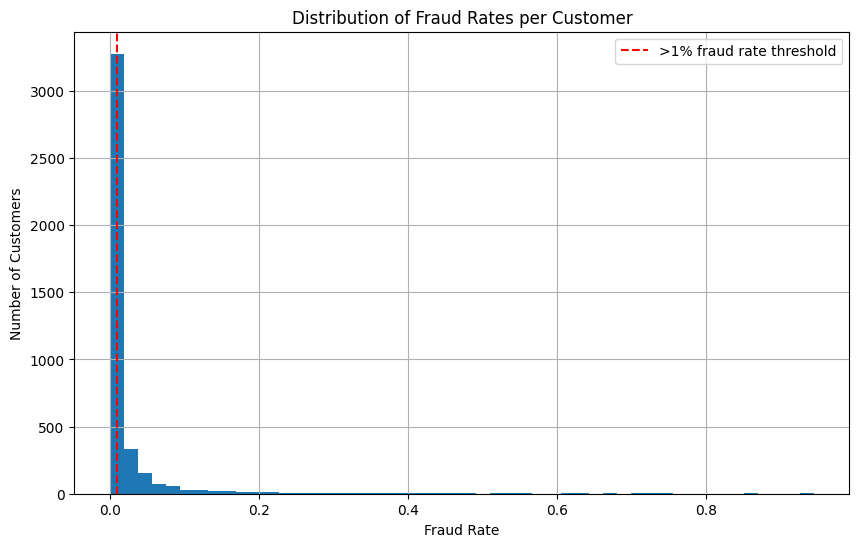

In [31]:
# 4. Plot distribution of fraud rates per customer
plt.figure(figsize=(10, 6))
fraud_per_customer.hist(bins=50)
plt.title('Distribution of Fraud Rates per Customer')
plt.xlabel('Fraud Rate')
plt.ylabel('Number of Customers')
plt.grid(True)
plt.axvline(x=0.01, color='r', linestyle='--', label='>1% fraud rate threshold')
plt.legend()
plt.show()

In [32]:
if len(high_fraud_customers) > 0:
    print("\nTop 10 customers with highest fraud rates:")
    top_fraudsters = high_fraud_customers.sort_values(ascending=False).head(10)
    for customer, rate in top_fraudsters.items():
        customer_txns = df_raw[df_raw['customer'] == customer]
        print(f"Customer: {customer}, Fraud Rate: {rate:.2%}, Transactions: {len(customer_txns)}, Fraudulent: {customer_txns['fraud'].sum()}")


Top 10 customers with highest fraud rates:
Customer: 'C910454738', Fraud Rate: 94.57%, Transactions: 92, Fraudulent: 87
Customer: 'C2004941826', Fraud Rate: 94.44%, Transactions: 126, Fraudulent: 119
Customer: 'C381007057', Fraud Rate: 89.00%, Transactions: 100, Fraudulent: 89
Customer: 'C1572610482', Fraud Rate: 88.12%, Transactions: 101, Fraudulent: 89
Customer: 'C617723960', Fraud Rate: 86.96%, Transactions: 46, Fraudulent: 40
Customer: 'C2113737065', Fraud Rate: 86.81%, Transactions: 91, Fraudulent: 79
Customer: 'C2060410910', Fraud Rate: 84.62%, Transactions: 13, Fraudulent: 11
Customer: 'C483912131', Fraud Rate: 81.63%, Transactions: 98, Fraudulent: 80
Customer: 'C1809646275', Fraud Rate: 80.00%, Transactions: 5, Fraudulent: 4
Customer: 'C1817318774', Fraud Rate: 77.68%, Transactions: 112, Fraudulent: 87


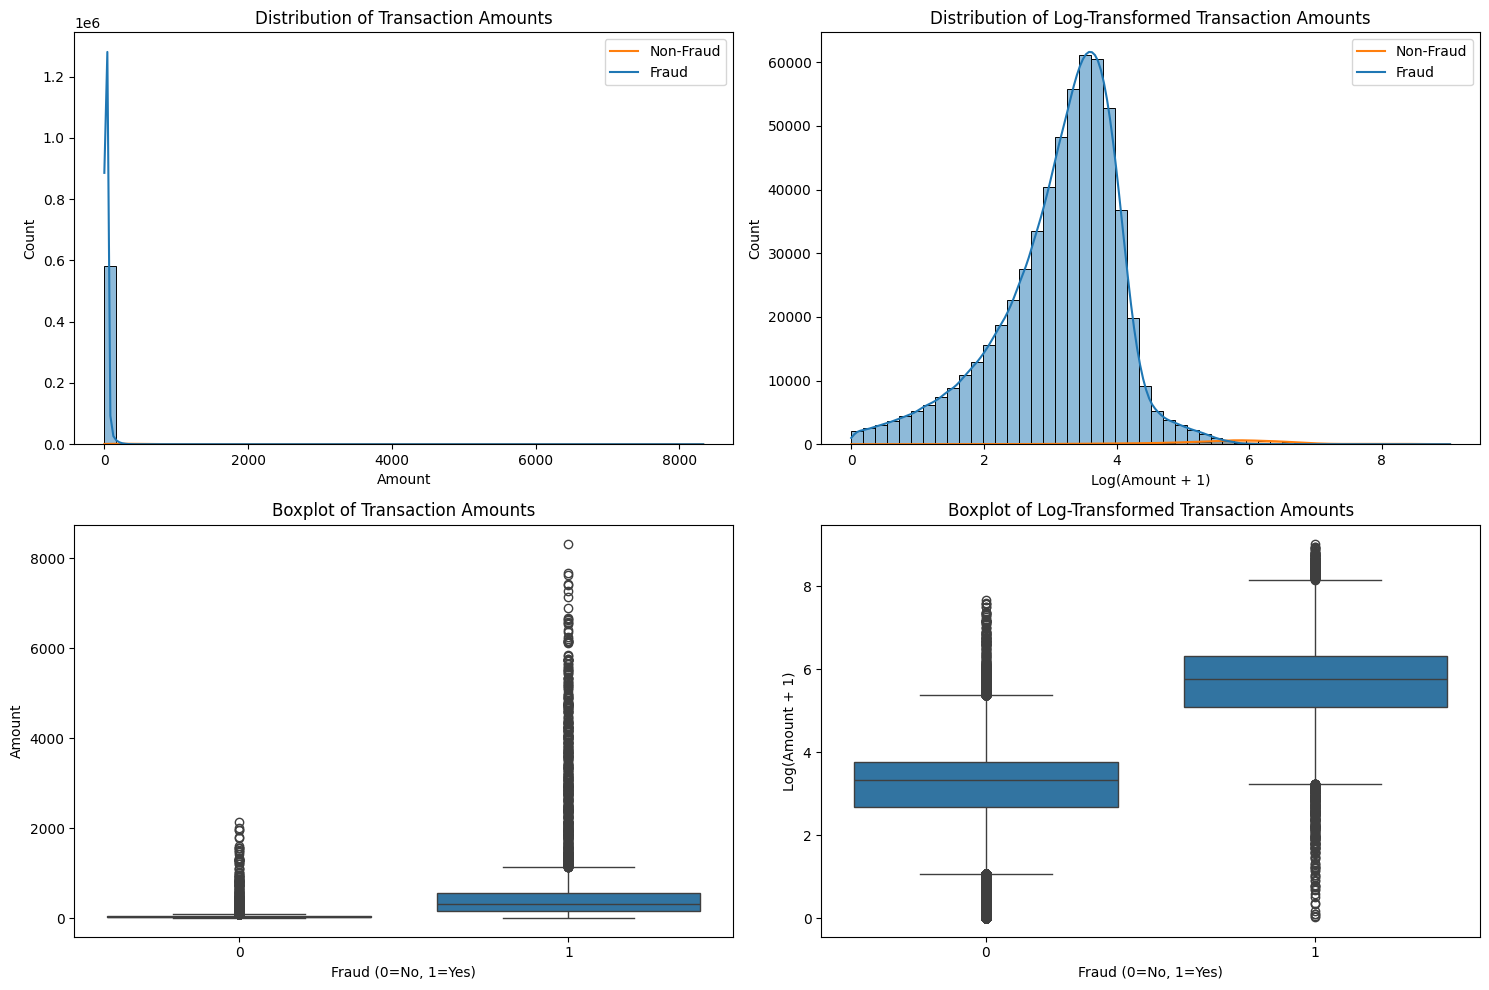

Amount statistics for non-fraudulent transactions:
count    587443.000000
mean         31.847230
std          31.470876
min           0.000000
25%          13.590000
50%          26.610000
75%          41.895000
max        2144.860000
Name: amount, dtype: float64

Amount statistics for fraudulent transactions:
count    7200.000000
mean      530.926551
std       835.587112
min         0.030000
25%       159.980000
50%       319.175000
75%       548.977500
max      8329.960000
Name: amount, dtype: float64


In [34]:
# Amount distribution by class: Comparing fraud vs non-fraud transactions
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create a figure with multiple subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Raw amount distribution - Histogram
sns.histplot(data=df_raw, x='amount', hue='fraud', 
             bins=50, kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Transaction Amounts')
axes[0,0].set_xlabel('Amount')
axes[0,0].set_ylabel('Count')
axes[0,0].legend(['Non-Fraud', 'Fraud'])

# 2. Log-transformed amount distribution - Histogram
# Add small constant to handle zero amounts before log transformation
df_raw['log_amount'] = np.log(df_raw['amount'] + 1)
sns.histplot(data=df_raw, x='log_amount', hue='fraud', 
             bins=50, kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribution of Log-Transformed Transaction Amounts')
axes[0,1].set_xlabel('Log(Amount + 1)')
axes[0,1].set_ylabel('Count')
axes[0,1].legend(['Non-Fraud', 'Fraud'])

# 3. Raw amount - Boxplot
sns.boxplot(data=df_raw, x='fraud', y='amount', ax=axes[1,0])
axes[1,0].set_title('Boxplot of Transaction Amounts')
axes[1,0].set_xlabel('Fraud (0=No, 1=Yes)')
axes[1,0].set_ylabel('Amount')

# 4. Log-transformed amount - Boxplot
sns.boxplot(data=df_raw, x='fraud', y='log_amount', ax=axes[1,1])
axes[1,1].set_title('Boxplot of Log-Transformed Transaction Amounts')
axes[1,1].set_xlabel('Fraud (0=No, 1=Yes)')
axes[1,1].set_ylabel('Log(Amount + 1)')

plt.tight_layout()
plt.show()

# Statistical summary of amounts by fraud class
print("Amount statistics for non-fraudulent transactions:")
print(df_raw[df_raw['fraud']==0]['amount'].describe())

print("\nAmount statistics for fraudulent transactions:")
print(df_raw[df_raw['fraud']==1]['amount'].describe())